In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [3]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000322,0.043957
2,12/04/1958,317.69,14,0.000643,0.047869
3,19/04/1958,317.58,21,0.000965,0.046737
4,26/04/1958,316.48,28,0.001286,0.035413


In [5]:
min(mauna_loa['norm_y']), max(mauna_loa['norm_y']), min(mauna_loa['norm_day']), max(mauna_loa['norm_day'])

(0.0, 1.0, 0.0, 1.0)

In [5]:
2 * np.pi / (365.25 / day_range)

374.4967669741262

In [ ]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

In [ ]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

In [ ]:
from pandas.plotting import autocorrelation_plot, lag_plot

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(mauna_loa['norm_y'], ax)

In [ ]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(y_diffs, ax)

In [ ]:
second_diffs = [y - x for x, y in zip(y_diffs, y_diffs[1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(second_diffs, ax)

In [ ]:
t_diffs = [y - x for x, y in zip(y_diffs, y_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t_diffs, ax)

In [ ]:
t2_diffs = [y - x for x, y in zip(t_diffs, t_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t2_diffs, ax)

In [ ]:
corr = np.correlate(t_diffs, t_diffs, 'same')
half_corr = corr[corr.shape[0] // 2:]
fig = plt.figure(figsize=(12, 8))
plt.plot(half_corr)

In [ ]:
np.argmax(half_corr[1:])

In [ ]:
import statsmodels.api as sm

dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)

fig = plt.figure(figsize=(12, 8))
resplot = res.plot()

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.trend)

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.seasonal[1000:1200])

## This does not look promising. In the mean time, let's go for a different model

**TODO:**
* Compare different polynomial degrees
* Convert regression to feature vector
* Consider setting local slope as an MA rather than linear regression
* Importance sampling for model comparison?
* Triangular wave with steeper downwards slope?

In [4]:
# TRAIN_SIZE = 1040
# TEST_SIZE = 1040
# train = mauna_loa[:TRAIN_SIZE]
# test = mauna_loa[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

TEST_SIZE = 0.25
N = len(mauna_loa)

train = mauna_loa[:int(-N * TEST_SIZE)]
test = mauna_loa[int(-N * TEST_SIZE):]
len(mauna_loa), len(train), len(test)

(3040, 2280, 760)

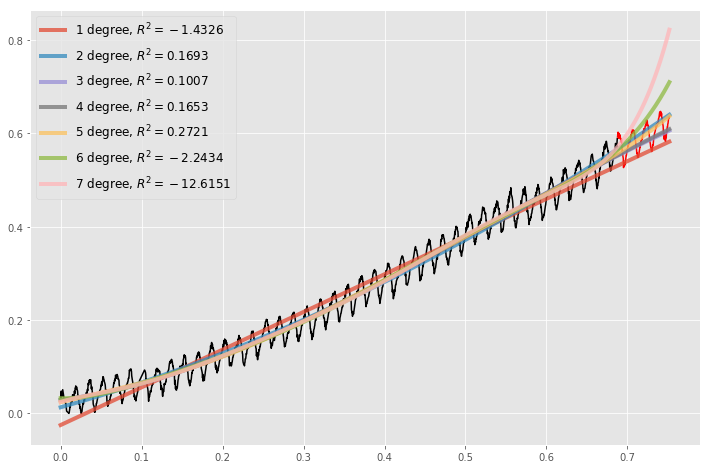

In [10]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

from sklearn.linear_model import Ridge, LassoLarsIC, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.asarray(train['norm_day']).reshape(-1, 1)
y = np.asarray(train['norm_y'])

X_train = X[:-200]
y_train = y[:-200]
X_test = X[-200:]
y_test = y[-200:]

fig = plt.figure(figsize=(12, 8))
plt.plot(X_train, y_train, color='black')
plt.plot(X_test, y_test, color='red')

for count, degree in enumerate(range(1, 8)):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # LassoLarsIC(criterion='bic'))
    model.fit(X_train, y_train)
#     ic = np.sum(model.steps[1][1].criterion_)
    y_plot = model.predict(X)
    plt.plot(X, y_plot, lw=4, alpha=0.75,
             label='{d} degree, $R^2 = {r2:.4f}$'.format(d=degree, r2=model.score(X_test, y_test)))
#             label='{d} degree, $R^2 = {r2:.4f}$, ic = {ic:.3e}'.format(
#                 d=degree, r2=model.score(X_test, y_test), ic=ic))

plt.legend(loc=2, fontsize=12)

In [15]:
sinuosdial_model = """
functions {
    vector poly_features(real t, int poly_deg) {
        vector[poly_deg] features;
        for (i in 1:poly_deg){
            features[i] = t ^ (i - 1);
        }
        return features;
    }

    real poly_trend(real t_i, vector b, int poly_deg) {
        return dot_product(b, poly_features(t_i, poly_deg));
    }
    
    real cos_seasonality(real t_i, real alpha, real unbound_omega, real phi) {
        return alpha * cos(unbound_omega * t_i + phi);
    }

    real poly_cos_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi) {
        return poly_trend(t_i, b, poly_deg) + cos_seasonality(t_i, alpha, unbound_omega, phi);
    }
}


data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N_future] t_future;      // the days
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
    int<lower=1> poly_degree;
}

parameters {
    vector[poly_degree] b;

    real unbound_omega; // the frequency parameter, in its unbound form
    real phi_x; // x and y coordinate to atan2 the phase shift from
    real phi_y;
    real unbound_alpha; // the amplitude frequency in its unbound form
    // real unbound_sigma_y; // overall prediction residual error
    real<lower=0> sigma_y;
}

transformed parameters {
    real phi;
    real<lower=0> alpha;
    
    phi = atan2(phi_x, phi_y);
    alpha = exp(unbound_alpha);
}

model {
    // Priors
    b[1] ~ normal(0, 0.2);
    for (i in 2:poly_degree) {
        b[i] ~ normal(0, 1);
    }
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    unbound_omega ~ normal(unbound_omega_zero, unbound_omega_zero / 6);
    unbound_alpha ~ normal(unbound_alpha_zero, 1);
    sigma_y ~ gamma(1, 5);
    
    for (i in 1:N) {
        y[i] ~ normal(poly_cos_model_mean(t[i], b, poly_degree, alpha, unbound_omega, phi), sigma_y);
    }
}

generated quantities {
    real y_simulated_train[N];
    real y_future[N_future];
    
    for(i in 1:N) {
        y_simulated_train[i] = normal_rng(poly_cos_model_mean(t[i], b, poly_degree, alpha, unbound_omega, phi), sigma_y);
    }
    
    for(i in 1:N_future) {
        y_future[i] = normal_rng(poly_cos_model_mean(t_future[i], b, poly_degree, alpha, unbound_omega, phi), sigma_y);
    }
}
"""

sm = pystan.StanModel(model_code=sinuosdial_model, model_name='sinusodial_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sinusodial_model_d5a8945c8e98d365137f943705c6dcf6 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmpeohrb6rh/stanfit4sinusodial_model_d5a8945c8e98d365137f943705c6dcf6_9189748637222262607.pyx because it changed.
[1/1] Cythonizing /tmp/tmpeohrb6rh/stanfit4sinusodial_model_d5a8945c8e98d365137f943705c6dcf6_9189748637222262607.pyx
building 'stanfit4sinusodial_model_d5a8945c8e98d365137f943705c6dcf6_9189748637222262607' extension
creating /tmp/tmpeohrb6rh/tmp
creating /tmp/tmpeohrb6rh/tmp/tmpeohrb6rh
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpeohrb6rh -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/anaconda3/lib/python3.6/site-packages/pystan

In [16]:
unbound_omega_zero = 2 * np.pi / (365.25 / day_range)
print(unbound_omega_zero)
unbound_alpha_zero = -3
polynomial_terms = 4

sinusodial_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
    'poly_degree': polynomial_terms
}

fit = sm.sampling(data=sinusodial_data, iter=1000, chains=4, n_jobs=4, verbose=True,
                  init=lambda: {'b': [0] * polynomial_terms, 
                                'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                'unbound_alpha': unbound_alpha_zero, 'unbound_sigma_y': -1, 
                                'sigma_y': np.exp(-1),
                               }
                  )

samples = fit.extract()
fit

374.4967669741262


Inference for Stan model: sinusodial_model_d5a8945c8e98d365137f943705c6dcf6.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]                      0.02  2.6e-5 7.8e-4   0.02   0.02   0.02   0.03   0.03    864    nan
b[1]                       0.3  3.5e-4 8.7e-3   0.28   0.29    0.3   0.31   0.32    635   1.01
b[2]                      1.11  1.1e-3   0.03   1.06   1.09   1.11   1.13   1.16    610   1.01
b[3]                      -0.6  9.3e-4   0.02  -0.65  -0.62   -0.6  -0.59  -0.56    619   1.01
unbound_omega           374.69  1.2e-3   0.04 374.61 374.66 374.69 374.72 374.78   1323    1.0
phi_x                    -0.63    0.02    0.3  -1.35  -0.82  -0.59  -0.41  -0.17    388   1.01
phi_y                     1.14    0.03   0.54   0.32   0.73   1.06   1.47   2.41    390   1.01
unbound_alpha            -3.55  2.2e-4 9.1e-3  

In [5]:
def plot_samples(samples):
    fig = plt.figure(figsize=(12, 16))
    gs = gridspec.GridSpec(2, 1)

    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)
    
    y_future_lower = np.percentile(samples['y_future'], 2.5, axis=0)
    y_future_upper = np.percentile(samples['y_future'], 97.5, axis=0)
    
    y_simulated_lower = np.percentile(samples['y_simulated_train'], 2.5, axis=0)
    y_simulated_upper = np.percentile(samples['y_simulated_train'], 97.5, axis=0)

    top_ax = plt.subplot(gs[0, 0])
    mauna_loa.plot(x='norm_day', y='norm_y', color='black', ax=top_ax)
    top_ax.fill_between(train['norm_day'], y_simulated_lower, y_simulated_upper, alpha=0.75, facecolor='green')
    top_ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.5, facecolor='blue')
#     left_ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
#                     y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.35, facecolor='blue')

    bottom_ax = plt.subplot(gs[1, 0])
    bottom_ax.plot(test['norm_day'], test['norm_y'], color='black')
    bottom_ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.35, facecolor='blue')
    
    mse = np.mean((test['norm_y'] - y_future_means) ** 2)
    print(mse)
    
    plt.show()


plot_samples(samples)

NameError: name 'samples' is not defined

In [ ]:

y_test = test['norm_y'].as_matrix()
y_mean = np.mean(samples['y_future'], axis=0)
np.mean((y_test - y_mean) ** 2)

In [ ]:
y_test.shape

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(range(samples['b'].shape[0]), [b[1] for b in samples['b']])

In [ ]:
samples['b'].shape

In [ ]:
import pickle

In [ ]:
with open('model_samples.pickle', 'wb') as out_file:
    pickle.dump(samples, out_file)

## Trying a asymmetrical triangular wave model

In [20]:
triangle_model = """
functions {
    vector poly_features(real t, int poly_deg) {
        vector[poly_deg] features;
        for (i in 1:poly_deg){
            features[i] = t ^ (i - 1);
        }
        return features;
    }

    real poly_trend(real t_i, vector b, int poly_deg) {
        return dot_product(b, poly_features(t_i, poly_deg));
    }
    
    real cos_seasonality(real t_i, real alpha, real unbound_omega, real phi) {
        return alpha * cos(unbound_omega * t_i + phi);
    }
    
    real asym_trinagle_seasonality(real t_i, real alpha, real unbound_omega, real phi, real min_point) {
        real x = fmod(t_i * unbound_omega + phi, 2 * pi());
        if (x < min_point) {
            return alpha * (1 - (2 * x / min_point));
        }
        
        return alpha * (2 * x - min_point - 2 * pi()) / (2 * pi() - min_point);
    }

    real poly_cos_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi) {
        return poly_trend(t_i, b, poly_deg) + cos_seasonality(t_i, alpha, unbound_omega, phi);
    }
    
    real poly_tri_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi, real min_point) {
        return poly_trend(t_i, b, poly_deg) + asym_trinagle_seasonality(t_i, alpha, unbound_omega, phi, min_point);
    }
}

data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N_future] t_future;      // the days
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
    int<lower=1> poly_degree;
}

parameters {
    vector[poly_degree] b;

    real unbound_omega; // the frequency parameter, in its unbound form
    real phi_x; // x and y coordinate to atan2 the phase shift from
    real phi_y;
    real unbound_alpha; // the amplitude frequency in its unbound form
    real<lower=0> sigma_y; // overall prediction residual error
    
    real min_point_x; // x and y coordinate to atan2 the min point from
    real min_point_y;
}

transformed parameters {
    real phi;
    real<lower=0> alpha;
    real min_point;
    
    phi = atan2(phi_x, phi_y);
    alpha = exp(unbound_alpha);
    
    min_point = atan2(min_point_x, min_point_y) + pi();
}

model {
    // Priors
    b[1] ~ normal(0, 0.2);
    for (i in 2:poly_degree) {
        b[i] ~ normal(0, 1);
    }
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    unbound_omega ~ normal(unbound_omega_zero, unbound_omega_zero / 6);
    unbound_alpha ~ normal(unbound_alpha_zero, 1);
    sigma_y ~ gamma(1, 5);
    
    min_point_x ~ normal(0, 1);
    min_point_y ~ normal(0, 1);
    
    for (i in 1:N) {
        y[i] ~ normal(poly_tri_model_mean(t[i], b, poly_degree, alpha, unbound_omega, phi, min_point), sigma_y);
    }
}

generated quantities {
    real y_simulated_train[N];
    real y_future[N_future];
    
    for(i in 1:N) {
        y_simulated_train[i] = normal_rng(poly_tri_model_mean(t[i], b, poly_degree, alpha, unbound_omega, phi, min_point), sigma_y); 
    }
    
    for(i in 1:N_future) {
        y_future[i] = normal_rng(poly_tri_model_mean(t_future[i], b, poly_degree, alpha, unbound_omega, phi, min_point), sigma_y);
    }
}
"""

tri_model = pystan.StanModel(model_code=triangle_model, model_name='triangle_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL triangle_model_e2179243b0b6f6dad8706f2a21de4d2a NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmpcd978bzy/stanfit4triangle_model_e2179243b0b6f6dad8706f2a21de4d2a_6534397265815601932.pyx because it changed.
[1/1] Cythonizing /tmp/tmpcd978bzy/stanfit4triangle_model_e2179243b0b6f6dad8706f2a21de4d2a_6534397265815601932.pyx
building 'stanfit4triangle_model_e2179243b0b6f6dad8706f2a21de4d2a_6534397265815601932' extension
creating /tmp/tmpcd978bzy/tmp
creating /tmp/tmpcd978bzy/tmp/tmpcd978bzy
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpcd978bzy -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/

In [21]:
unbound_omega_zero = 2 * np.pi / (365.25 / day_range)
print(unbound_omega_zero)
unbound_alpha_zero = -3
polynomial_terms = 4

triangular_model_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
    'poly_degree': polynomial_terms
}

tri_fit = tri_model.sampling(data=triangular_model_data, iter=1000, chains=4, n_jobs=4, verbose=True,
                             init=lambda: {'b': [0] * polynomial_terms, 
                                'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                'unbound_alpha': unbound_alpha_zero, 'sigma_y': 0.1,
                               }
                  )

tri_samples = tri_fit.extract()
tri_fit

374.4967669741262


Inference for Stan model: triangle_model_e2179243b0b6f6dad8706f2a21de4d2a.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]                      0.02  2.3e-5 6.4e-4   0.02   0.02   0.02   0.02   0.02    780    nan
b[1]                      0.32  3.0e-4 7.2e-3    0.3   0.31   0.32   0.32   0.33    556    1.0
b[2]                      1.07  9.5e-4   0.02   1.03   1.06   1.07   1.08   1.11    522    1.0
b[3]                     -0.57  8.3e-4   0.02  -0.61  -0.59  -0.57  -0.56  -0.54    518    1.0
unbound_omega           374.59  1.1e-3   0.03 374.53 374.57 374.59 374.61 374.65    764    1.0
phi_x                    -1.05    0.03   0.47  -2.14  -1.34  -0.99  -0.68  -0.35    311   1.01
phi_y                     0.73    0.02   0.33   0.24   0.47   0.69   0.93   1.49    306   1.02
unbound_alpha            -3.33  1.8e-4 7.1e-3  -3

0.004928256303399452


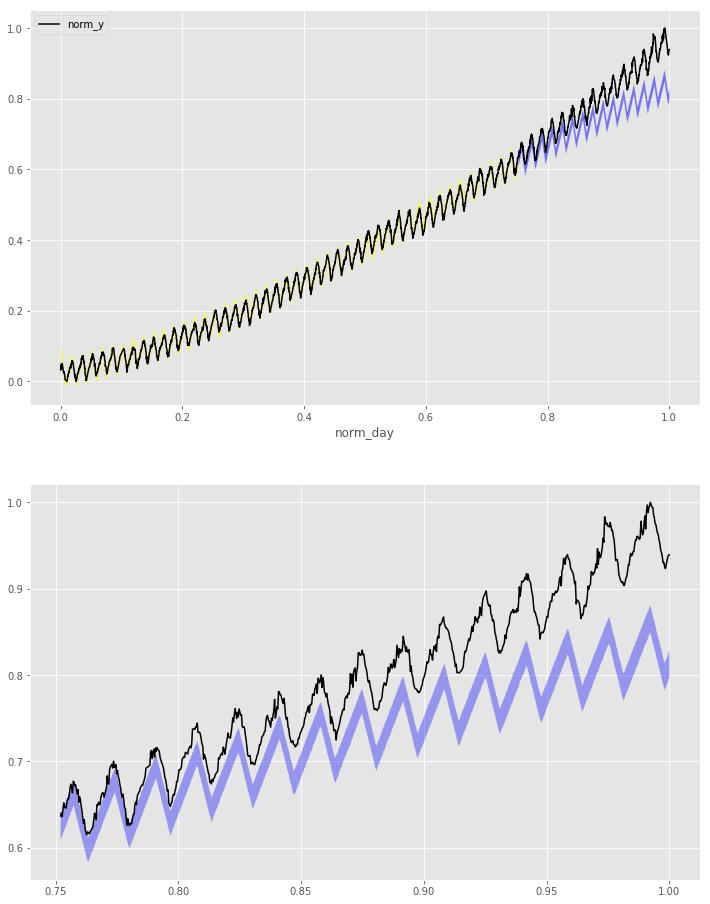

In [22]:
plot_samples(tri_samples)

## Triangle model with constrained positive polynomial coefficients

In [91]:
positive_poly_triangle_model = """
functions {
    vector poly_features(real t, int poly_deg) {
        vector[poly_deg] features;
        for (i in 1:poly_deg){
            features[i] = t ^ (i - 1);
        }
        return features;
    }

    real poly_trend(real t_i, vector b, int poly_deg) {
        return dot_product(b, poly_features(t_i, poly_deg));
    }
    
    real cos_seasonality(real t_i, real alpha, real unbound_omega, real phi) {
        return alpha * cos(unbound_omega * t_i + phi);
    }
    
    real asym_trinagle_seasonality(real t_i, real alpha, real unbound_omega, real phi, real min_point) {
        real x = fmod(t_i * unbound_omega + phi, 2 * pi());
        if (x < min_point) {
            return alpha * (1 - (2 * x / min_point));
        }
        
        return alpha * (2 * x - min_point - 2 * pi()) / (2 * pi() - min_point);
    }

    real poly_cos_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi) {
        return poly_trend(t_i, b, poly_deg) + cos_seasonality(t_i, alpha, unbound_omega, phi);
    }
    
    real poly_tri_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi, real min_point) {
        return poly_trend(t_i, b, poly_deg) + asym_trinagle_seasonality(t_i, alpha, unbound_omega, phi, min_point);
    }
}

data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N_future] t_future;      // the days
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
    int<lower=1> poly_degree;
}

parameters {
    // vector[poly_degree] b;
    vector[poly_degree] b;

    real unbound_omega; // the frequency parameter, in its unbound form
    real phi_x; // x and y coordinate to atan2 the phase shift from
    real phi_y;
    real unbound_alpha; // the amplitude frequency in its unbound form
    real<lower=0> sigma_y; // overall prediction residual error
    
    real min_point_x; // x and y coordinate to atan2 the min point from
    real min_point_y;
}

transformed parameters {
    real phi;
    real<lower=0> alpha;
    real min_point;
    vector<lower=0>[poly_degree] positive_b;
    
    phi = atan2(phi_x, phi_y);
    alpha = exp(unbound_alpha);
    
    min_point = atan2(min_point_x, min_point_y) + pi();
    positive_b = exp(b);
}

model {
    // Priors
    b[1] ~ normal(0, 0.2);
    for (i in 2:poly_degree) {
        b[i] ~ normal(0, 1);
    }
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    unbound_omega ~ normal(unbound_omega_zero, unbound_omega_zero / 6);
    unbound_alpha ~ normal(unbound_alpha_zero, 1);
    sigma_y ~ gamma(1, 5);
    
    min_point_x ~ normal(0, 1);
    min_point_y ~ normal(0, 1);
    
    for (i in 1:N) {
        y[i] ~ normal(poly_tri_model_mean(t[i], positive_b, poly_degree, alpha, unbound_omega, phi, min_point), sigma_y);
    }
}

generated quantities {
    real y_simulated_train[N];
    real y_future[N_future];
    
    for(i in 1:N) {
        y_simulated_train[i] = normal_rng(poly_tri_model_mean(t[i], positive_b, poly_degree, alpha, unbound_omega, phi, min_point), sigma_y); 
    }
    
    for(i in 1:N_future) {
        y_future[i] = normal_rng(poly_tri_model_mean(t_future[i], positive_b, poly_degree, alpha, unbound_omega, phi, min_point), sigma_y);
    }
}
"""

positive_tri_model = pystan.StanModel(model_code=positive_poly_triangle_model, 
                                      model_name='positive_poly_triangle_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL positive_poly_triangle_model_2c77446e8c0e56b5a44d601c197dc413 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmp0ymvqviy/stanfit4positive_poly_triangle_model_2c77446e8c0e56b5a44d601c197dc413_3316428730066811021.pyx because it changed.
[1/1] Cythonizing /tmp/tmp0ymvqviy/stanfit4positive_poly_triangle_model_2c77446e8c0e56b5a44d601c197dc413_3316428730066811021.pyx
building 'stanfit4positive_poly_triangle_model_2c77446e8c0e56b5a44d601c197dc413_3316428730066811021' extension
creating /tmp/tmp0ymvqviy/tmp
creating /tmp/tmp0ymvqviy/tmp/tmp0ymvqviy
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmp0ymvqviy -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/anaconda

In [92]:
unbound_omega_zero = 2 * np.pi / (365.25 / day_range)
print(unbound_omega_zero)
unbound_alpha_zero = -3
polynomial_terms = 4

positive_triangular_model_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
    'poly_degree': polynomial_terms
}

positive_tri_fit = positive_tri_model.sampling(data=positive_triangular_model_data, 
                                      iter=1000, chains=4, n_jobs=4, verbose=True,
                             init=lambda: {'b': [0] * polynomial_terms, 
                                'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                'unbound_alpha': unbound_alpha_zero, 'sigma_y': 0.1,
                               }
                  )

positive_tri_samples = positive_tri_fit.extract()
positive_tri_fit

374.4967669741262


Inference for Stan model: positive_poly_triangle_model_2c77446e8c0e56b5a44d601c197dc413.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[0]                     -4.36  1.4e-3   0.04  -4.44  -4.39  -4.36  -4.34  -4.29    846   1.01
b[1]                     -0.69  2.4e-4 6.4e-3   -0.7  -0.69  -0.69  -0.68  -0.68    729   1.01
b[2]                     -0.85  3.7e-4   0.01  -0.87  -0.85  -0.85  -0.84  -0.83    750   1.01
b[3]                     -5.53    0.01   0.39  -6.35  -5.79  -5.52  -5.26  -4.81    956    1.0
unbound_omega           374.61  1.1e-3   0.04 374.54 374.59 374.61 374.64 374.68   1028    1.0
phi_x                    -1.21    0.03   0.53  -2.38  -1.56  -1.17  -0.79  -0.39    233   1.02
phi_y                     0.81    0.02   0.36   0.26   0.52   0.77   1.04    1.6    229   1.02
unbound_alpha            -3.32  2.2

0.00011983705187506328


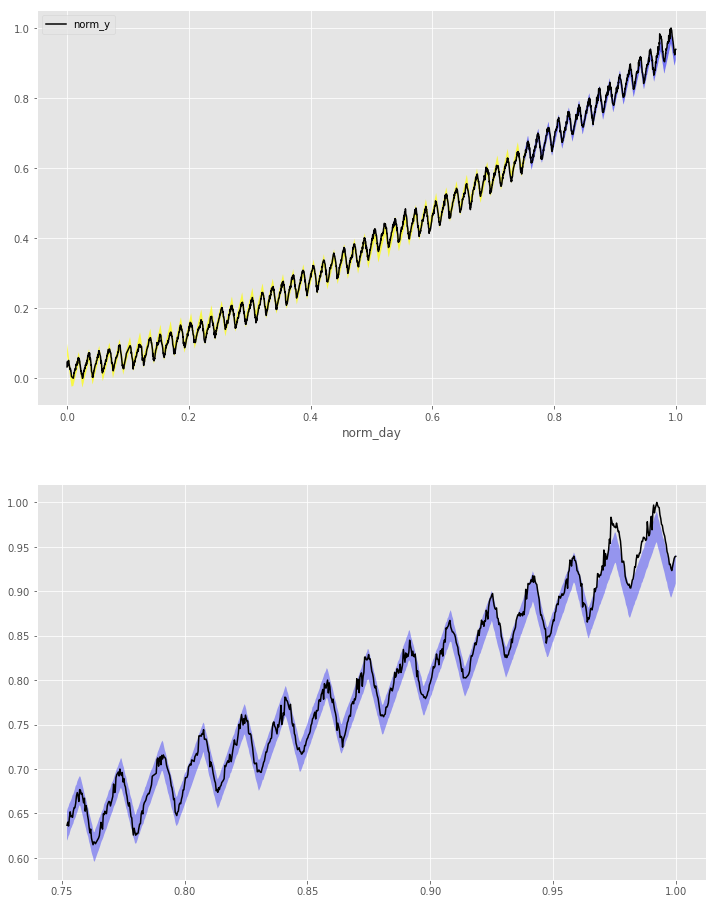

In [93]:
plot_samples(positive_tri_samples)

In [94]:
import pickle
with open('positive_tri_samples_2.pickle', 'wb') as out_file:
    pickle.dump(positive_tri_samples, out_file)

OrderedDict([('b', array([[-4.34810534, -0.68609823, -0.85399498, -5.35436246],
                     [-4.28406096, -0.69788011, -0.83563271, -5.4924614 ],
                     [-4.37254899, -0.68755539, -0.8458741 , -5.89186816],
                     ..., 
                     [-4.38551651, -0.68745387, -0.84553969, -5.51221872],
                     [-4.41049901, -0.6863289 , -0.84740275, -5.43369106],
                     [-4.25772358, -0.70059456, -0.83758802, -5.40752105]])),
             ('unbound_omega',
              array([ 374.66216346,  374.65043316,  374.60720536, ...,  374.6606616 ,
                      374.65751349,  374.62565966])),
             ('phi_x',
              array([-0.85495986, -0.37120057, -0.96204855, ..., -1.60951134,
                     -0.94581765, -0.71185698])),
             ('phi_y',
              array([ 0.52914467,  0.2434145 ,  0.73243991, ...,  0.95330853,
                      0.61305612,  0.46739059])),
             ('unbound_alpha',
           

## Trying a piecewise model for the trend

In [67]:
piecewise_model = """
functions {
    real piecewise_trend(real t_i, int num_splits, vector splits, vector intercepts, vector slopes) {
        for (s in 1:num_splits){
            if (t_i > splits[s]) {
                return intercepts[s + 1] + t_i * slopes[s + 1];
            }
        }
        
        return intercepts[1] + t_i * slopes[1];
    }
    
    real cos_seasonality(real t_i, real alpha, real unbound_omega, real phi) {
        return alpha * cos(unbound_omega * t_i + phi);
    }

    real piecewise_cos_model_mean(real t_i, int num_splits, vector splits, vector intercepts, vector slopes, real alpha, real unbound_omega, real phi) {
        return piecewise_trend(t_i, num_splits, splits, intercepts, slopes) + cos_seasonality(t_i, alpha, unbound_omega, phi);
    }
}

data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N_future] t_future;      // the days
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
    int<lower=1> num_splits;
}

parameters {
    real unbound_omega; // the frequency parameter, in its unbound form
    real phi_x; // x and y coordinate to atan2 the phase shift from
    real phi_y;
    real unbound_alpha; // the amplitude frequency in its unbound form
    real<lower=0> sigma_y;
    
    // piecewise regression parameters
    // int<lower=1> num_splits;
    ordered[num_splits] splits;
    vector[num_splits + 1] intercepts;
    vector[num_splits + 1] slopes;
}

transformed parameters {
    real phi;
    real<lower=0> alpha;
    vector[num_splits] split_means;
    vector<lower=0>[num_splits] split_sds;
    
    phi = atan2(phi_x, phi_y);
    alpha = exp(unbound_alpha);
    
    for (s in 1:num_splits) {
        split_means[s] = t[N] * s / (num_splits + 1);
        split_sds[s] = 1 / (num_splits + 4);
    }
}

model {
    // Priors
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    unbound_omega ~ normal(unbound_omega_zero, unbound_omega_zero / 6);
    unbound_alpha ~ normal(unbound_alpha_zero, 1);
    sigma_y ~ gamma(1, 5);
    
    for (s in 1:num_splits) {
        splits[s] ~ normal(split_means[s], split_sds[s] + 0.01);
    }
    
    for (s in 1:(num_splits + 1)) {
        intercepts[s] ~ normal(0, 1);
        slopes[s] ~ normal(0, 1);
    }
    
    for (i in 1:N) {
        y[i] ~ normal(piecewise_cos_model_mean(t[i], num_splits, splits, intercepts, slopes, alpha, unbound_omega, phi), sigma_y);
    }
}

generated quantities {
    real y_simulated_train[N];
    real y_future[N_future];
    
    for(i in 1:N) {
        y_simulated_train[i] = normal_rng(piecewise_cos_model_mean(t[i], num_splits, splits, intercepts, slopes, alpha, unbound_omega, phi), sigma_y);
    }
    
    for(i in 1:N_future) {
        y_future[i] = normal_rng(piecewise_cos_model_mean(t_future[i], num_splits, splits, intercepts, slopes, alpha, unbound_omega, phi), sigma_y);
    }
}
"""

pm = pystan.StanModel(model_code=piecewise_model, model_name='piecewise_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL piecewise_model_488bb85b18d577666ddfe4cf84af57a3 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmpftdsolea/stanfit4piecewise_model_488bb85b18d577666ddfe4cf84af57a3_7470404708873207408.pyx because it changed.
[1/1] Cythonizing /tmp/tmpftdsolea/stanfit4piecewise_model_488bb85b18d577666ddfe4cf84af57a3_7470404708873207408.pyx
building 'stanfit4piecewise_model_488bb85b18d577666ddfe4cf84af57a3_7470404708873207408' extension
creating /tmp/tmpftdsolea/tmp
creating /tmp/tmpftdsolea/tmp/tmpftdsolea
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpftdsolea -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/st

In [68]:
unbound_omega_zero = 2 * np.pi / (365.25 / day_range)
print(unbound_omega_zero)
unbound_alpha_zero = -3
num_splits = 3


piecewise_model_data = {
    'N': len(train),
    'N_future': len(test),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
    'num_splits': num_splits
}

train_t_max = max(train['norm_day'])
split_means = [(s + 1) * train_t_max / (num_splits + 1) for s in range(num_splits)]

piecewise_fit = pm.sampling(data=piecewise_model_data, 
                                      iter=1000, chains=4, n_jobs=4, verbose=True,
                             init=lambda: {
                                 'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                 'unbound_alpha': unbound_alpha_zero, 'sigma_y': 0.1,
                                 'splits': split_means,
                                 'split_means': split_means,
                                 'split_sds': [1 / (num_splits + 4) for _ in range(num_splits)]
                               }
                  )

piecewise_samples = piecewise_fit.extract()
piecewise_fit

374.4967669741262


Inference for Stan model: piecewise_model_488bb85b18d577666ddfe4cf84af57a3.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
unbound_omega           374.51    0.02   0.03 374.47 374.48  374.5 374.53 374.54      2   13.9
phi_x                    -0.21    0.65   0.92  -1.57   -1.0  -0.16   0.58   1.02      2 149.62
phi_y                    -0.98    0.48   0.68  -1.68  -1.58  -1.16  -0.34   0.08      2 614.87
unbound_alpha            -4.01    1.23   1.73   -7.5  -4.76  -3.03  -3.01  -2.99      2  15.65
sigma_y                   0.14    0.07    0.1   0.02   0.04   0.16   0.24   0.25      2  88.95
splits[0]                 0.17    0.03   0.05   0.13   0.14   0.16   0.21   0.25      2  15.91
splits[1]                 0.36    0.03   0.04   0.31   0.32   0.35    0.4   0.44      2  15.72
splits[2]                 0.55    0.03   0.05   

0.09995833839198387


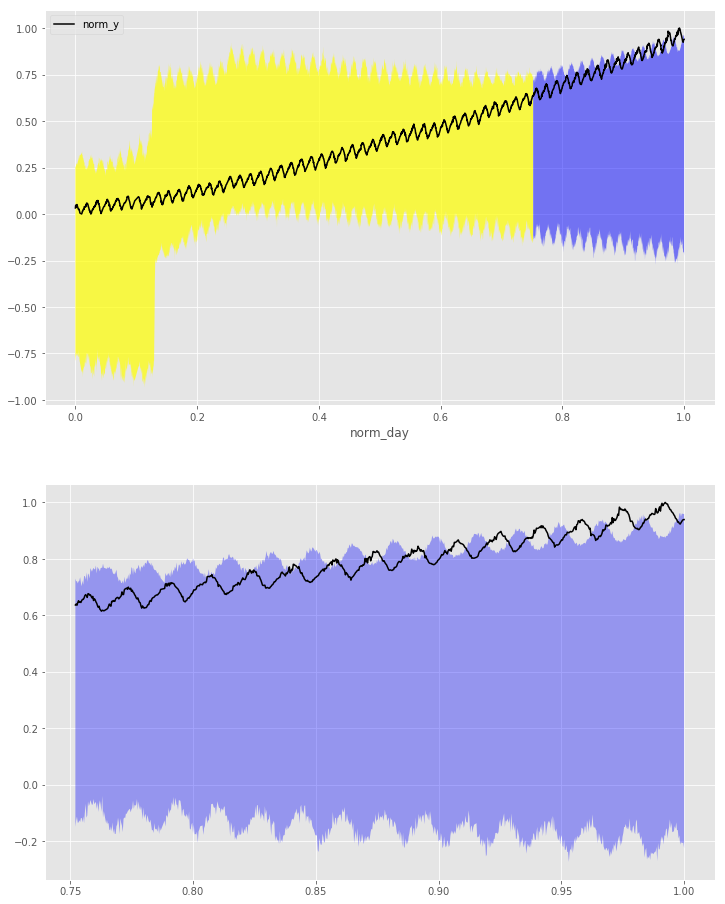

In [70]:
plot_samples(piecewise_samples)

## One last effort - adding a long-term sinusodial piece

Since the residual plot form the best model appears to show something of a sinsusodial trends, let's see if we can counteract it

In [18]:
positive_poly_long_sin_model = """
functions {
    vector poly_features(real t, int poly_deg) {
        vector[poly_deg] features;
        for (i in 1:poly_deg){
            features[i] = t ^ (i - 1);
        }
        return features;
    }

    real poly_trend(real t_i, vector b, int poly_deg) {
        return dot_product(b, poly_features(t_i, poly_deg));
    }
    
    real cos_seasonality(real t_i, real alpha, real unbound_omega, real phi) {
        return alpha * cos(unbound_omega * t_i + phi);
    }
    
    real sin_seasonality(real t_i, real alpha, real unbound_omega, real phi) {
        return alpha * sin(unbound_omega * t_i + phi);
    }
    
    real asym_trinagle_seasonality(real t_i, real alpha, real unbound_omega, real phi, real min_point) {
        real x = fmod(t_i * unbound_omega + phi, 2 * pi());
        if (x < min_point) {
            return alpha * (1 - (2 * x / min_point));
        }
        
        return alpha * (2 * x - min_point - 2 * pi()) / (2 * pi() - min_point);
    }

    real poly_cos_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi) {
        return poly_trend(t_i, b, poly_deg) + cos_seasonality(t_i, alpha, unbound_omega, phi);
    }
    
    real poly_tri_model_mean(real t_i, vector b, int poly_deg, real alpha, real unbound_omega, real phi, real min_point) {
        return poly_trend(t_i, b, poly_deg) + asym_trinagle_seasonality(t_i, alpha, unbound_omega, phi, min_point);
    }
    
    real poly_tri_long_sin_model_mean(real t_i, vector b, int poly_deg, 
            real alpha, real unbound_omega, real phi, real min_point, 
            real long_term_alpha, real unbound_long_term_omega_zero, real long_term_phi) {
        return poly_trend(t_i, b, poly_deg) + 
               asym_trinagle_seasonality(t_i, alpha, unbound_omega, phi, min_point) +
               sin_seasonality(t_i, long_term_alpha, unbound_long_term_omega_zero, long_term_phi);
    }
}

data {
    int<lower=0> N; // number of data points
    int<lower=0> N_future; // number of 'future' test set data points
    int<lower=0> N_predict; // number of prdiction data points to generate into the future
    vector[N] y;      // observed CO2 values
    vector[N] t;      // the days
    vector[N_future] t_future;      // the days to test on
    vector[N_predict] t_predict;      // the days to test on
    real unbound_omega_zero;  // the initial omega
    real unbound_alpha_zero;  // the initial alpha
    int<lower=1> poly_degree;
    // parameters for the long-term sinusodial trend
    real long_term_unbound_omega_zero;  // the initial long term omega
    real long_term_unbound_alpha_zero;  // the initial long term alpha
}

parameters {
    // overall prediction residual error
    real<lower=0> sigma_y; 
        
    // parameters for the polynomial trend
    vector[poly_degree] b;

    // parameters for any periodic behavior
    real unbound_omega; // the frequency parameter, in its unbound form
    real phi_x; // x and y coordinate to atan2 the phase shift from
    real phi_y;
    real unbound_alpha; // the amplitude frequency in its unbound form
    
    // parameters for the triangular wave
    real min_point_x; // x and y coordinate to atan2 the triangle wave min point with
    real min_point_y;
    
    // parameters for the long-term sinusodial trend
    real long_term_unbound_omega;
    real long_term_phi_x; // x and y coordinate to atan2 the phase shift from
    real long_term_phi_y;
    real long_term_unbound_alpha;
}

transformed parameters {
    real phi;
    real<lower=0> alpha;
    real min_point;
    // vector<lower=0>[poly_degree] positive_b;
    // parameters for the long-term sinusodial trend
    real long_term_phi;
    real<lower=0> long_term_alpha;
    
    phi = atan2(phi_x, phi_y);
    alpha = exp(unbound_alpha);
    
    min_point = atan2(min_point_x, min_point_y) + pi();
    // positive_b = exp(b);
    
    long_term_phi = atan2(long_term_phi_x, long_term_phi_y);
    long_term_alpha = exp(long_term_unbound_alpha);
}

model {
    // Priors
    b[1] ~ normal(0, 1);
    for (i in 2:poly_degree) {
        b[i] ~ normal(0, 1);
    }
    
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    
    unbound_omega ~ normal(unbound_omega_zero, unbound_omega_zero / 6);
    unbound_alpha ~ normal(unbound_alpha_zero, 1);
    sigma_y ~ gamma(1, 5);
    
    min_point_x ~ normal(0, 1);
    min_point_y ~ normal(0, 1);
    
    long_term_unbound_omega ~ normal(long_term_unbound_omega_zero, unbound_omega_zero / 6);
    long_term_unbound_alpha ~ normal(long_term_unbound_alpha_zero, 1);
    
    for (i in 1:N) {
        y[i] ~ normal(poly_tri_long_sin_model_mean(t[i], b, poly_degree, 
            alpha, unbound_omega, phi, min_point,
            long_term_alpha, long_term_unbound_omega, long_term_phi), sigma_y);
    }
}

generated quantities {
    real y_simulated_train[N];
    real y_future[N_future];
    real y_predict[N_predict];
    
    for(i in 1:N) {
        y_simulated_train[i] = normal_rng(poly_tri_long_sin_model_mean(t[i], b, poly_degree, 
            alpha, unbound_omega, phi, min_point,
            long_term_alpha, long_term_unbound_omega, long_term_phi), sigma_y);
    }
    
    for(i in 1:N_future) {
        y_future[i] = normal_rng(poly_tri_long_sin_model_mean(t_future[i], b, poly_degree, 
            alpha, unbound_omega, phi, min_point,
            long_term_alpha, long_term_unbound_omega, long_term_phi), sigma_y);
    }
    
    for(i in 1:N_predict) {
        y_predict[i] = normal_rng(poly_tri_long_sin_model_mean(t_predict[i], b, poly_degree, 
            alpha, unbound_omega, phi, min_point,
            long_term_alpha, long_term_unbound_omega, long_term_phi), sigma_y);
    }
}
"""

positive_tri_long_sin_model = pystan.StanModel(model_code=positive_poly_long_sin_model, 
                                      model_name='positive_poly_long_sin_triangle_model', verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL positive_poly_long_sin_triangle_model_abe5e6db5198bb1484048974cc4e7716 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 12:22:00) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)], Cython 0.27.3


Compiling /tmp/tmpcaz0_315/stanfit4positive_poly_long_sin_triangle_model_abe5e6db5198bb1484048974cc4e7716_1607421025937808595.pyx because it changed.
[1/1] Cythonizing /tmp/tmpcaz0_315/stanfit4positive_poly_long_sin_triangle_model_abe5e6db5198bb1484048974cc4e7716_1607421025937808595.pyx
building 'stanfit4positive_poly_long_sin_triangle_model_abe5e6db5198bb1484048974cc4e7716_1607421025937808595' extension
creating /tmp/tmpcaz0_315/tmp
creating /tmp/tmpcaz0_315/tmp/tmpcaz0_315
gcc -pthread -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpcaz0_315 -I/opt/anaconda3/lib/python3.6/site-packages/pystan -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/src -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/anaconda3/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/b

In [19]:
t_values = mauna_loa['norm_day'].as_matrix()
t_step = t_values[-1] - t_values[-2]
t_fourty_years = np.asarray(list(t_values[-1] + t_step * i * 7 for i in range(int(40 * 362.25 / 7))))

In [20]:
unbound_omega_zero = 2 * np.pi / (365.25 / day_range)
print(unbound_omega_zero)
unbound_alpha_zero = -3
polynomial_terms = 4
long_term_unbound_omega_zero = 2 * np.pi * 1.1
long_term_unbound_alpha_zero = np.log(0.03)

positive_tri_long_sin_model_data = {
    'N': len(train),
    'N_future': len(test),
    'N_predict': len(t_fourty_years),
    'y': train['norm_y'],
    't': train['norm_day'],
    't_future': test['norm_day'],
    't_predict': t_fourty_years,
    'unbound_omega_zero': unbound_omega_zero,
    'unbound_alpha_zero': unbound_alpha_zero,
    'poly_degree': polynomial_terms,
    'long_term_unbound_omega_zero': long_term_unbound_omega_zero,
    'long_term_unbound_alpha_zero': long_term_unbound_alpha_zero
}

positive_tri_long_sin_fit = positive_tri_long_sin_model.sampling(data=positive_tri_long_sin_model_data, 
                                                        iter=1000, chains=4, n_jobs=4, verbose=True,
                                                        init=lambda: {'b': [0] * polynomial_terms, 
                                           'unbound_omega': unbound_omega_zero, 'unbound_phi': 0, 
                                           'unbound_alpha': unbound_alpha_zero, 'sigma_y': 0.1,
                                           'long_term_unbound_omega_zero': long_term_unbound_omega_zero,
                                           'long_term_unbound_alpha_zero': long_term_unbound_alpha_zero
                               }
                  )

positive_tri_long_sin_samples = positive_tri_long_sin_fit.extract()
positive_tri_long_sin_fit

374.4967669741262


KeyboardInterrupt: 

0.0004769489251447489


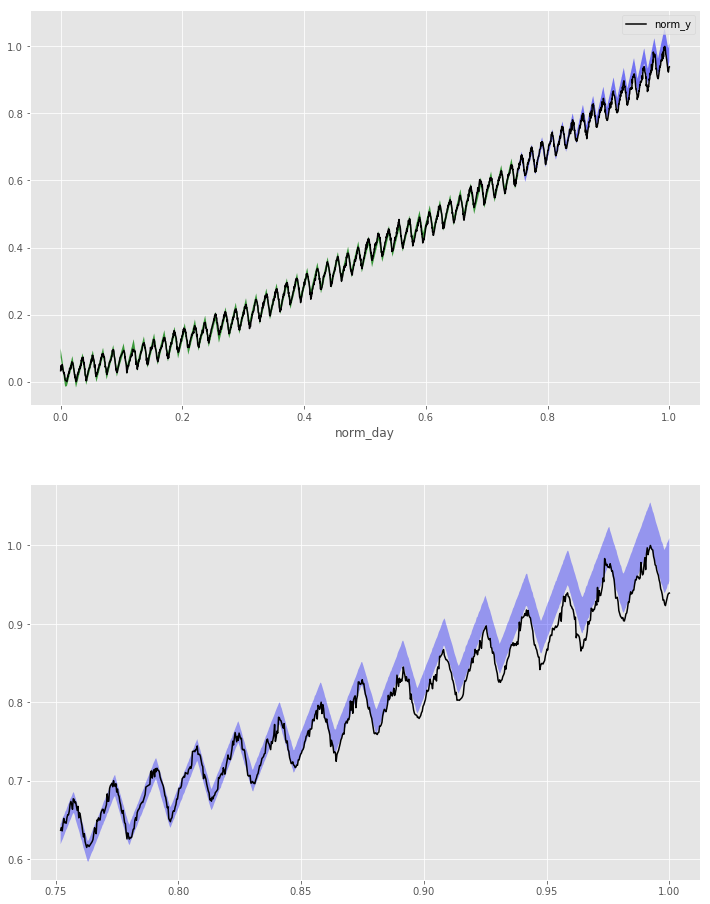

In [10]:
plot_samples(positive_tri_long_sin_samples)

In [11]:
import pickle
with open('positive_tri_long_sin_samples_final.pickle', 'wb') as out_file:
    pickle.dump(positive_tri_long_sin_samples, out_file)

In [81]:
np.log(0.03)

-3.5065578973199818

In [ ]:
def plot_samples(samples):
    fig = plt.figure(figsize=(12, 16))
    gs = gridspec.GridSpec(2, 1)

    y_future_means = np.mean(samples['y_future'], axis=0)
    y_future_stds = np.std(samples['y_future'], axis=0)
    
    y_future_lower = np.percentile(samples['y_future'], 2.5, axis=0)
    y_future_upper = np.percentile(samples['y_future'], 97.5, axis=0)
    
    y_simulated_lower = np.percentile(samples['y_simulated_train'], 2.5, axis=0)
    y_simulated_upper = np.percentile(samples['y_simulated_train'], 97.5, axis=0)

    top_ax = plt.subplot(gs[0, 0])
    mauna_loa.plot(x='norm_day', y='norm_y', color='black', ax=top_ax)
    top_ax.fill_between(train['norm_day'], y_simulated_lower, y_simulated_upper, alpha=0.75, facecolor='green')
    top_ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.5, facecolor='blue')
#     left_ax.fill_between(test['norm_day'][:future], y_future_means[:future] - 2 * y_future_stds[:future], 
#                     y_future_means[:future] + 2 * y_future_stds[:future], alpha=0.35, facecolor='blue')

    bottom_ax = plt.subplot(gs[1, 0])
    bottom_ax.plot(test['norm_day'], test['norm_y'], color='black')
    bottom_ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.35, facecolor='blue')
    
    mse = np.mean((test['norm_y'] - y_future_means) ** 2)
    print(mse)
    
    plt.show()


plot_samples(samples)

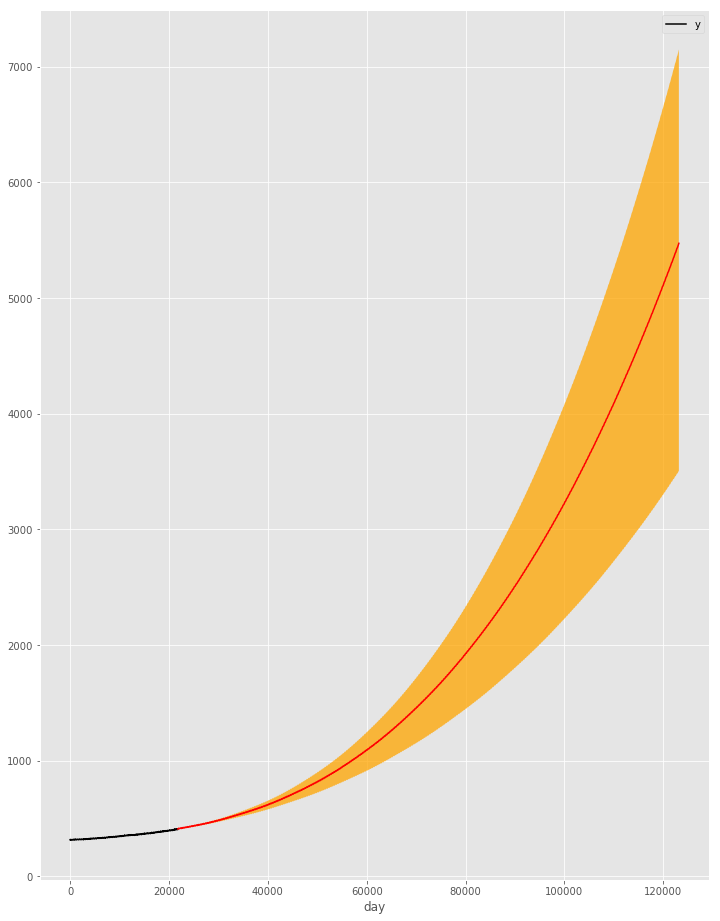

In [17]:
samples = positive_tri_long_sin_samples

ax = mauna_loa.plot(x='day', y='y', color='black', figsize=(12, 16))

y_simulated_lower = np.percentile(samples['y_simulated_train'], 2.5, axis=0) * y_range + y_min
y_simulated_upper = np.percentile(samples['y_simulated_train'], 97.5, axis=0) * y_range + y_min
ax.fill_between(train['day'], y_simulated_lower, y_simulated_upper, alpha=0.75, facecolor='green',
               label='Train 95% confidence interval')

y_future_lower = np.percentile(samples['y_future'], 2.5, axis=0) * y_range + y_min
y_future_upper = np.percentile(samples['y_future'], 97.5, axis=0) * y_range + y_min
ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.75, facecolor='blue',
               label='Test 95% confidence interval')    


t_forty_years_plot = t_fourty_years * day_range
y_pred_means = np.mean(samples['y_predict'], axis=0) * y_range + y_min
ax.plot(t_forty_years_plot, y_pred_means, color='red', label='Forty years future predictions')

y_pred_lower = np.percentile(samples['y_predict'], 2.5, axis=0) * y_range + y_min
y_pred_upper = np.percentile(samples['y_predict'], 97.5, axis=0) * y_range + y_min
ax.fill_between(t_forty_years_plot, y_pred_lower, y_pred_upper, facecolor='orange', alpha=0.75,
                label='Forty years 95% confidence interval')

plt.show()

In [21]:
t_values = mauna_loa['norm_day'].as_matrix()
t_step = t_values[-1] - t_values[-2]
t_fourty_years = np.asarray(list(t_values[-1] + (t_step * i * 7) for i in range(int(40 * 362.25 / 7))))

In [26]:
t_fourty_years[200]

1.4501607717041445

In [25]:
t_fourty_years[-1], t_fourty_years[-1] * day_range

(5.6569131832793751, 123150.999999992)

## Post-mortem fix

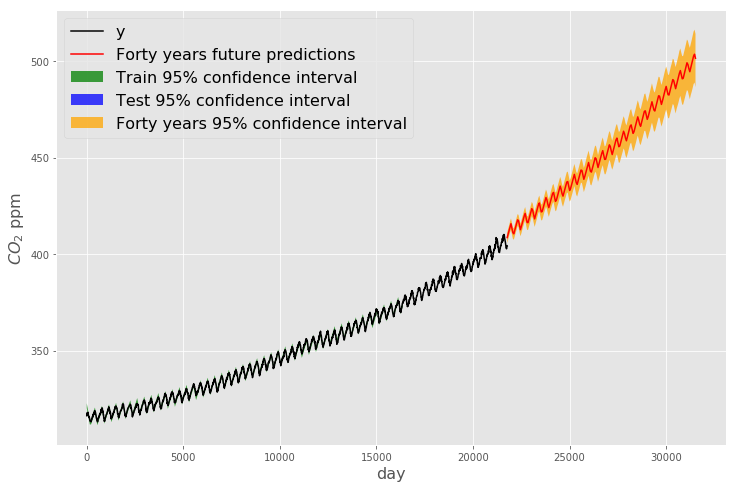

In [34]:
samples = positive_tri_long_sin_samples

ax = mauna_loa.plot(x='day', y='y', color='black', figsize=(12, 8))

y_simulated_lower = np.percentile(samples['y_simulated_train'], 2.5, axis=0) * y_range + y_min
y_simulated_upper = np.percentile(samples['y_simulated_train'], 97.5, axis=0) * y_range + y_min
ax.fill_between(train['day'], y_simulated_lower, y_simulated_upper, alpha=0.75, facecolor='green',
               label='Train 95% confidence interval')

y_future_lower = np.percentile(samples['y_future'], 2.5, axis=0) * y_range + y_min
y_future_upper = np.percentile(samples['y_future'], 97.5, axis=0) * y_range + y_min
ax.fill_between(test['norm_day'], y_future_lower, y_future_upper, alpha=0.75, facecolor='blue',
               label='Test 95% confidence interval')    


t_forty_years_plot = t_fourty_years * day_range
y_pred_means = np.mean(samples['y_predict'], axis=0) * y_range + y_min
ax.plot(t_forty_years_plot[:200], y_pred_means[:200], color='red', label='Forty years future predictions')

y_pred_lower = np.percentile(samples['y_predict'], 2.5, axis=0) * y_range + y_min
y_pred_upper = np.percentile(samples['y_predict'], 97.5, axis=0) * y_range + y_min
ax.fill_between(t_forty_years_plot[:200], y_pred_lower[:200], y_pred_upper[:200], facecolor='orange', alpha=0.75,
                label='Forty years 95% confidence interval')
ax.set_xlabel('day', fontsize=16)
ax.set_ylabel('$CO_2$ ppm', fontsize=16)
ax.legend(loc=2, fontsize=16)
plt.show()